# ** Xebia Part II: Machine Learning Pipeline**
0. **Pipeline**
    1. preprocessing pipeline

In [15]:
%matplotlib inline
import numpy as np
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
import random
import sys
sys.path.insert(0, '../')

from sklearn.preprocessing import LabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn_pandas import DataFrameMapper
from src.utils import WarrantyToFloat,FillByMax
from mlens.ensemble import SuperLearner
from mlens.metrics import make_scorer
from sklearn.metrics import mean_squared_error
import numpy as np

In [211]:
# Data loading
df_train = pd.read_csv('../data/mower_market_snapshot.csv',sep=';',
                     na_values='unknown')
target = df_train.loc[:,"attractiveness"]
target = np.log(1+target)
df_train = df_train.drop(["id","market_share","attractiveness"],axis=1)
df_test = pd.read_csv('../data/submission_set.csv',sep=';',na_values='unknown')
submission = df_test.loc[:,["id"]]
df_test = df_test.drop(["id"],axis=1)

In [175]:
df_test.head(2)

,capacity,failure_rate,margin,price,prod_cost,product_type,quality,warranty
0,21.313064,0.037928,613.061762,768.160605,155.098843,auto-portee,Medium,3 ans
1,25.797234,0.038664,701.321608,865.727540,164.405932,auto-portee,Low,3 ans


In [176]:
df_train.head(2)

,capacity,failure_rate,margin,price,prod_cost,product_type,quality,warranty
0,10.492623,0.042528,633.766584,828.802103,195.035519,auto-portee,Low,3ans
1,20.273730,0.037896,731.576817,882.894916,151.318099,auto-portee,Low,3 ans.


## Preprocessing pipeling

In [177]:
p = Pipeline([
    ('preprocessing',DataFrameMapper([ 
                ('product_type', LabelBinarizer()),
                ('quality', LabelBinarizer()),
                ('warranty',WarrantyToFloat()),
                                           ],input_df=True,default=None,df_out = True)),
     ('fill_by_max',FillByMax()) # this is only used for tree methodes
    
            ])
    

In [178]:
df_train_prepro = p.fit_transform(df_train)

In [179]:
df_train_prepro.head(2)

,product_type_auto-portee,product_type_electrique,product_type_essence,quality_Hight,quality_Low,quality_Medium,warranty,capacity,failure_rate,margin,price,prod_cost
0,1.0,0.0,0.0,0.0,1.0,0.0,3.0,10.492623,0.042528,633.766584,828.802103,195.035519
1,1.0,0.0,0.0,0.0,1.0,0.0,3.0,20.273730,0.037896,731.576817,882.894916,151.318099


## Grid search

### Xgboost

In [184]:
parameters = {'learning_rate': [0.05,0.1,0.2], #so called `eta` value
              'max_depth': [1,2,4,6],
              'min_child_weight': [10,15,20],
              'subsample': [0.8],
              'colsample_bytree': [0.6],
              'n_estimators': [30,50,80], #number of trees, change it to 1000 for better results
              'objective':["reg:linear"],
              'seed': [42],
               }

xgb_model = xgb.XGBRegressor()
clf_xgb = GridSearchCV(xgb_model, parameters, cv=5, 
                   scoring='neg_mean_squared_error',
                   verbose=1, refit=True,return_train_score=True)

_ = clf_xgb.fit(df_train_prepro,target)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:   17.0s finished


In [185]:
clf_xgb.best_params_

{'colsample_bytree': 0.6,
 'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 10,
 'n_estimators': 30,
 'objective': 'reg:linear',
 'seed': 42,
 'subsample': 0.8}

In [186]:
clf_xgb.best_score_

-0.0043139682521868925

### Random Forest

In [187]:
parameters = {"n_estimators":[3,5,8],
              "max_depth": [5,None],
              "max_features": [1, 2, 3],
              "min_samples_split": [2,3],
              "min_samples_leaf": [2,3],
              "random_state":[42]
                }

rf_model =  RandomForestRegressor()
clf_rf = GridSearchCV(rf_model, parameters, n_jobs=5,cv=5, 
                   scoring='neg_mean_squared_error',
                   verbose=1, refit=True,return_train_score=True)

_ = clf_rf.fit(df_train_prepro,target)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished


In [188]:
clf_rf.best_score_

-0.003559887938432307

## Stacking

### mlens

In [198]:
from sklearn.linear_model import LinearRegression,Ridge
ensemble = SuperLearner(scorer=mean_squared_error, folds=5, random_state=45, array_check=0, verbose=True)
ensemble.add([xgb.XGBRegressor(**clf_xgb.best_params_),
              RandomForestRegressor(**clf_rf.best_params_),
             ],)

ensemble.add(Ridge(fit_intercept=False))
ensemble.fit(df_train_prepro.values, target.values)


Fitting 2 layers
Fit complete                        | 00:00:00


SuperLearner(array_check=0, backend=None, folds=5,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=7115, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=5, raise_on_ex...955d90>)],
   n_jobs=-1, name='group-92', raise_on_exception=True, transformers=[])],
   verbose=0)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=45, sample_size=20,
       scorer=<function mean_squared_error at 0x10c955d90>, shuffle=False,
       verbose=True)

In [200]:
ensemble.data

Data([('score-m',
       OrderedDict([('layer-1/randomforestregressor', 0.003559264258393257),
                    ('layer-1/xgbregressor', 0.004312523754744447),
                    ('layer-2/ridge', 0.003956087258610271)])),
      ('score-s',
       OrderedDict([('layer-1/randomforestregressor', 0.001867237352710067),
                    ('layer-1/xgbregressor', 0.0036839498468570738),
                    ('layer-2/ridge', 0.0026759268857215715)])),
      ('ft-m',
       OrderedDict([('layer-1/randomforestregressor', 0.026811473199632018),
                    ('layer-1/xgbregressor', 0.02530581120008719),
                    ('layer-2/ridge', 0.0012499242002377287)])),
      ('ft-s',
       OrderedDict([('layer-1/randomforestregressor', 0.005614732024163316),
                    ('layer-1/xgbregressor', 0.003969784243041939),
                    ('layer-2/ridge', 0.00043319732300511194)])),
      ('pt-m',
       OrderedDict([('layer-1/randomforestregressor', 0.001575203999891528),
  

### Simple average

In [205]:
np.e**np.log(2)

1.9999999999999998

## Final submision 

In [161]:
df_test_prepro = p.transform(df_test)

In [213]:
submission["attractiveness"]=np.e**(clf_rf.predict(df_test_prepro)) -1

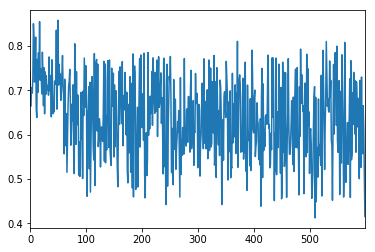

In [215]:
submission["attractiveness"].plot()

In [216]:
df_train = pd.read_csv('../data/mower_market_snapshot.csv',sep=';',
                     na_values='unknown')

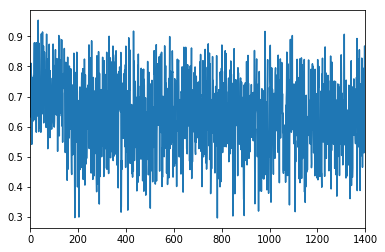

In [217]:
df_train["attractiveness"].plot()